In [17]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

conn_string = "host='localhost' dbname='gbot' user='postgres' password='123'"
conn = psycopg2.connect(conn_string)
if not conn.closed:
    print("Connected!")

Connected!


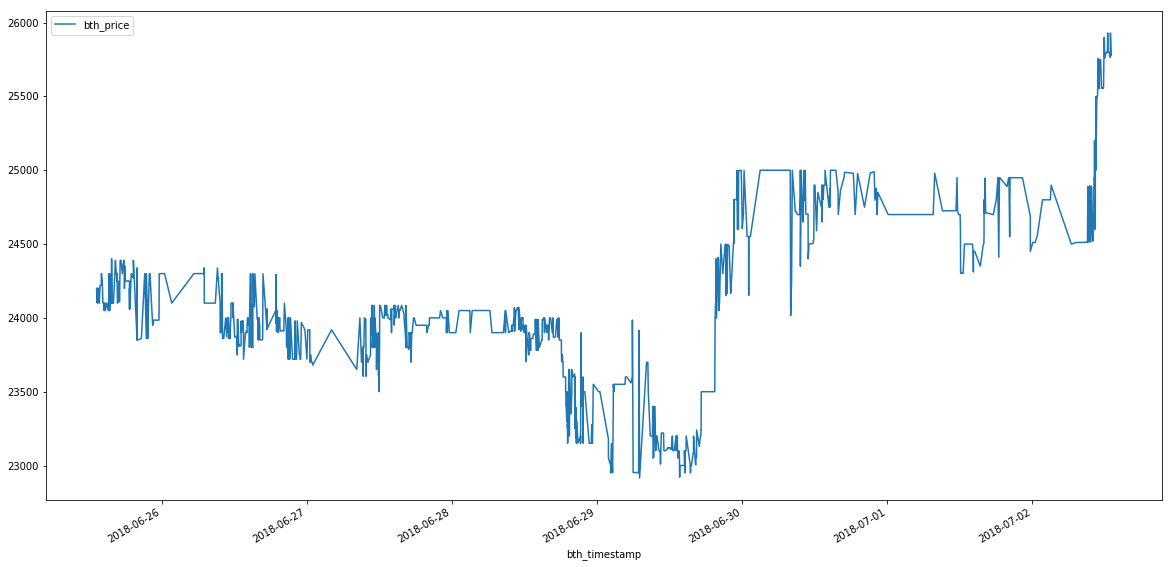

In [20]:
data = pd.read_sql_query("SELECT * FROM braziliex_trade_history WHERE bth_timestamp >= (now() - interval '1 week') AND bth_market = 'btc_brl'", conn)

data.plot(x="bth_timestamp", y="bth_price")